<a href="https://colab.research.google.com/github/jason-a-buell/BUS509/blob/main/module12_question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I, Jason Buell, am the sole contributor on this assignment.

In [ ]:
# import packages here
# derived from https://github.com/sarahJune1/BUS509_sachss/blob/main/notebooks/Module_12/ANOVA.ipynb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
!pip install bioinfokit
from bioinfokit.analys import stat
#from string import ascii_lowercase as lc
import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 84 kB 1.6 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56750 sha256=1532a38167c52e59a92c7caf22b8a0f2dbee4ca98635ac55932a45dda6b0f0c4
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=80b6af0e169dd8ff87da7c9347941f0af4767f194e05d2fcdba9baa88a96bf07
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


# Module Twelve: Analysis of Variance

In this module, we will learn about how to analyze the difference of variance between groups, called ANOVA. This builds upon our X<sup>2</sup> distribution and testing approaches and allows us to inform our decision about the differences between groups using statistics. We will also discuss some of the caveats when discretizing groups, called Simpson's paradox.


Exercises 13.1 - 1, 13 (4 points total)

Exercises 13.2 - 28 (2 points)

Exercises 13.3 - 41 (3 points)

Exercises 13.4 - 49, 51 (6 points)

For question 49 students must solve using the manual formulas, for 51 students may use the pre-built Stats models to solve. 

*The rationale:* our objective is to first understand the calculations used in the Stats package, and then to apply the automation tool. In order to effectively interpret the output, we need to establish the foundation to explain what's in the black box.

**Bonus:** For any of the questions from this homework, select one hypothesis test example/case study and describe the limitations of the experiment. Specifically as it relates to Type I and Type II errors and how the sample represents the intended population.


## Section 13.3 

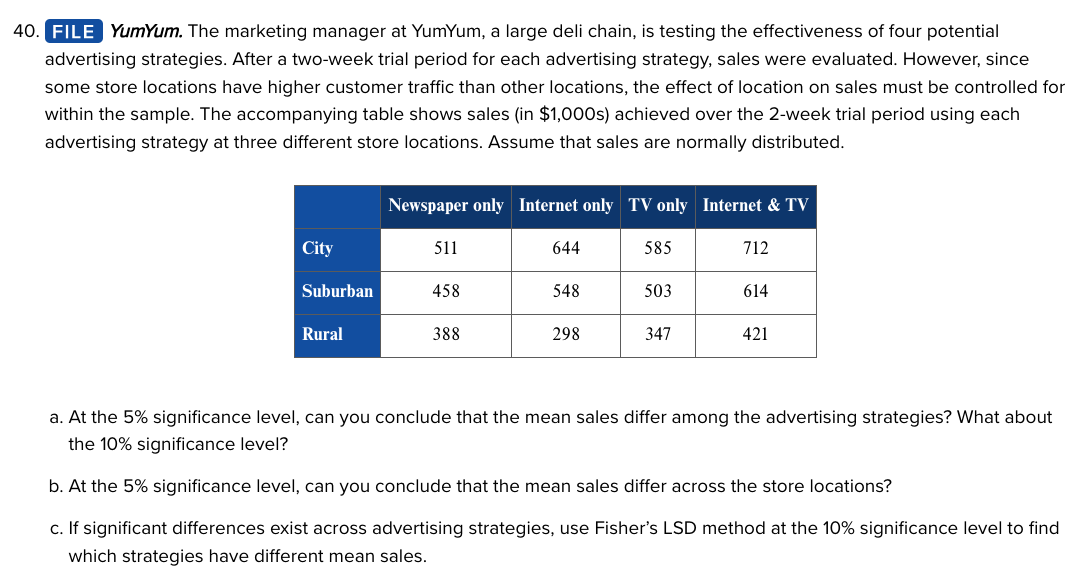

(3 points)

In [ ]:
# Source: https://github.com/sarahJune1/BUS509_sachss/blob/main/notebooks/Module_12/ANOVA.ipynb, line 39
def fisher_confidence_interval(x1_, x2_, MSE_, n1_, n2_, critical_val):
  upper_bound = (x1_ - x2_) + critical_val * math.sqrt(MSE_ * ((1/n1_) + (1/n2_)))
  lower_bound = (x1_ - x2_) - critical_val * math.sqrt(MSE_ * ((1/n1_) + (1/n2_)))
  return lower_bound, upper_bound

In [ ]:
# Calculates out confidence intervals from a dataframe under ideal conditions
# per standard/valid assumptions of the data given.
def fisher_cis_from_df(df, alpha):
  '''
  Calculates out confidence intervals from a dataframe under ideal conditions
  per standard/valid assumptions of the data given.
  Returns dict with keys of compared column names and values of the confidence limits as a list
  '''
  conf_ints = {}
  means = {}
  vars = {}
  sse = 0
  # get the columns
  for col in df.columns:
    means[col] = df[col].mean()
    vars[col] = df[col].var()
    sse = sse + (len(df) - 1) * df[col].var()

  ddof = (len(df)*len(df.columns)) - len(df.columns)
  mse = sse / ddof
  alpha_over_two = alpha / 2
  critical_value = stats.t.ppf(1 - alpha_over_two, ddof)
  for first_col, second_col in itertools.combinations(df.columns, 2):
    conf_ints[first_col + ' & ' + second_col] = \
      fisher_confidence_interval(means[first_col], means[second_col], mse, len(df[first_col]), len(df[second_col]), critical_value)
  return conf_ints


In [ ]:
#yum = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx", 
 #                      sheet_name='YumYum').set_index('Unnamed: 0')
yum = pd.read_excel("https://lectures.mhhe.com/connect/jaggia4e_1260719294/student/data_files/jaggia_BS_4e_ch13_Data_Files.xlsx", 
                       sheet_name='YumYum')

In [ ]:
yum

,Unnamed: 0,Newspaper only,Internet only,TV only,Internet & TV
0,City,511,644,585,712
1,Suburban,458,548,503,614
2,Rural,388,298,347,421


In [ ]:
yum_melt = pd.melt(yum, id_vars=['Unnamed: 0'], value_vars=['Newspaper only', 'Internet only', 'TV only', 'Internet & TV'])
yum_melt

,Unnamed: 0,variable,value
0,City,Newspaper only,511
1,Suburban,Newspaper only,458
2,Rural,Newspaper only,388
3,City,Internet only,644
4,Suburban,Internet only,548
5,Rural,Internet only,298
6,City,TV only,585
7,Suburban,TV only,503
8,Rural,TV only,347
9,City,Internet & TV,712


In [ ]:
yum_melt.columns = ['locations', 'strategies', 'value']
yum_melt

,locations,strategies,value
0,City,Newspaper only,511
1,Suburban,Newspaper only,458
2,Rural,Newspaper only,388
3,City,Internet only,644
4,Suburban,Internet only,548
5,Rural,Internet only,298
6,City,TV only,585
7,Suburban,TV only,503
8,Rural,TV only,347
9,City,Internet & TV,712


In [ ]:
res = stat()
res.anova_stat(df=yum_melt, res_var='value', anova_model='value~C(locations)+C(strategies)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(locations),2.0,129317.166667,64658.583333,25.547496,0.001161
C(strategies),3.0,28524.250000,9508.083333,3.756775,0.078798
Residual,6.0,15185.500000,2530.916667,NaN,NaN


a. For strategies, the findings are such that it is significant at 10%, but not significant at 5%.  This is drawn from the p-value in the last column.

b. For locations, our p-value is 0.001, thus indicating that we reject the null hypothesis at 5% significance level.

In [ ]:
yum = yum.drop(['Unnamed: 0'], axis=1)
yum

,Newspaper only,Internet only,TV only,Internet & TV
0,511,644,585,712
1,458,548,503,614
2,388,298,347,421


In [ ]:
fisher_cis_from_df(yum, .1)

{'Internet only & Internet & TV': (-289.7251759893877, 118.39184265605434),
 'Internet only & TV only': (-185.72517598938765, 222.3918426560544),
 'Newspaper only & Internet & TV': (-334.0585093227211, 74.05850932272097),
 'Newspaper only & Internet only': (-248.3918426560544, 159.72517598938765),
 'Newspaper only & TV only': (-230.05850932272102, 178.05850932272102),
 'TV only & Internet & TV': (-308.0585093227211, 100.05850932272097)}

In [ ]:
stats.f_oneway(yum[yum.columns[0]], yum[yum.columns[1]], yum[yum.columns[2]], yum[yum.columns[3]])

F_onewayResult(statistic=0.5263893630567371, pvalue=0.6763936684682239)

In [ ]:
# newspaper and internet comparison only for verification
npdf = yum['Newspaper only']
idf = yum['Internet only']
tvdf = yum['TV only']
itvdf = yum['Internet & TV']
var1 = npdf.var()
var2 = idf.var()
var3 = tvdf.var()
var4 = itvdf.var()
mean1 = npdf.mean()
mean2 = idf.mean()
nt = 12
c = 4
sse  = 2 * (var1 + var2 + var3 + var4)
mse = sse / (12 - 4)
mse
x1 = math.sqrt(mse * (1/3 + 1/3))
alpha_over_two = .1 / 2
ddof = nt - c
t_stat = stats.t.ppf(1 - alpha_over_two, ddof)
t_stat

(mean1 - mean2) - t_stat * x1


-248.3918426560544